In [1]:
import numpy as np
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask

from ekarus.e2e.pyramid_wfs import PyramidWFS
from ekarus.e2e.utils.create_field_from_zernike_coefficients import create_field_from_zernike_coefficients

def scale_plot_size(factor=1.5):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor

scale_plot_size(1.1)

In [3]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel=''):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar()
    cbar.ax.set_ylabel(zlabel)
    plt.show()

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= np.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/np.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m):
    return wavelength/pupil_diameter_in_m*rad2arcsec

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_41133/52879819.py:29: SyntaxWarning: invalid escape sequence '\p'
  xlabel=r'$\theta_{sky}$ [arcsec]', ylabel='$\phi_{sky}$ [arcsec]',


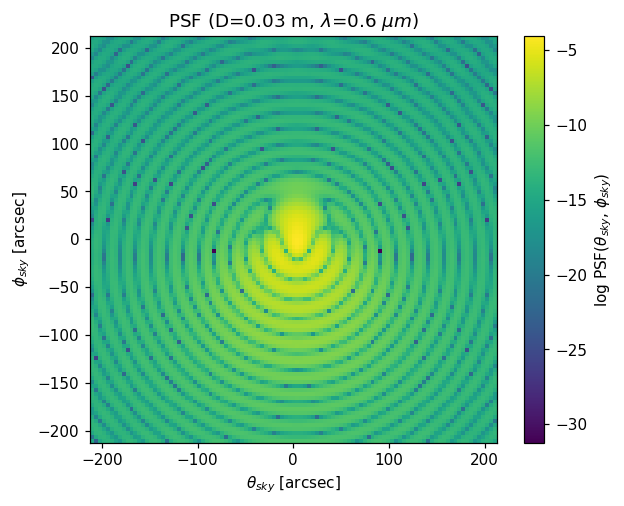

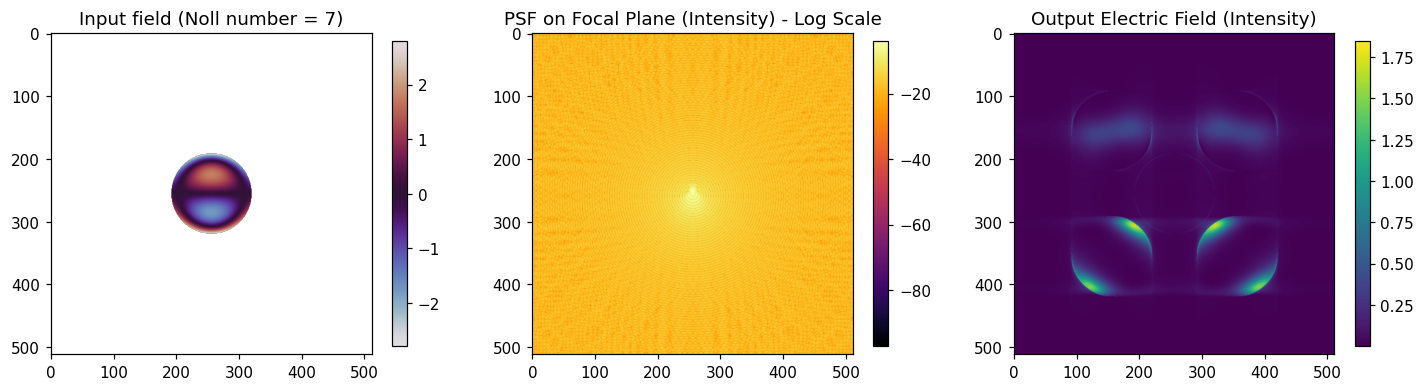

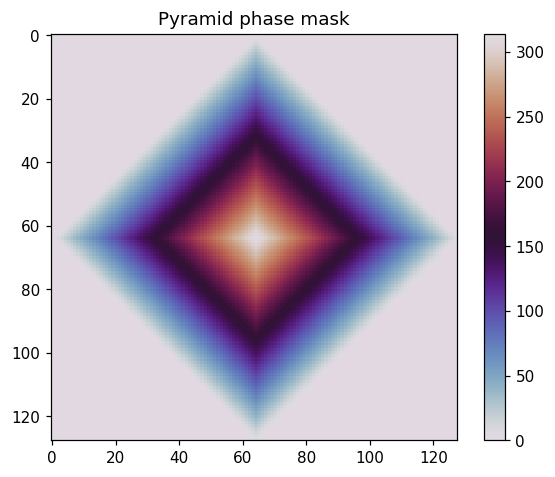

In [ ]:
nx = 128
# Parametri del sensore a piramide
apex_angle = np.pi*100 # vertex angle in radians, can be tricky to find the right value

# Create pupil mask
oversampling = 4
mask = CircularMask((oversampling * nx, oversampling * nx), maskRadius=nx // 2)

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 7
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Inizializzazione del sensore
wfs = PyramidWFS(apex_angle)

# Propagazione del campo attraverso il sensore
output_field = wfs.propagate(input_field)
intensity = np.abs(output_field**2)

# Compute normalized psf
psf = np.abs(np.abs(wfs.field_on_focal_plane**2))
psf *= 1/np.sum(psf)

pupilDiameterInM = 30e-3
lambdaInM = 600e-9
pix_scale = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM)
showZoomCenter(psf, pix_scale, title=r'PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel='$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)')

# Visualizzazione dei risultati
s = 0.45
plt.figure(1, figsize=(16,8))
plt.subplot(1, 3, 1)
#plt.title("Input Electric Field (Phase)")
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(np.angle(input_field), cmap='twilight')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
plt.title("PSF on Focal Plane (Intensity) - Log Scale")
plt.imshow(np.log( psf ), cmap='inferno')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 3)
plt.title("Output Electric Field (Intensity)")
plt.imshow(intensity)
plt.colorbar(shrink=s)
plt.show()

plt.figure(2)
plt.imshow(wfs.pyramid_phase_delay((nx, nx)), cmap='twilight')
plt.title("Pyramid phase mask")
plt.colorbar()
plt.show()

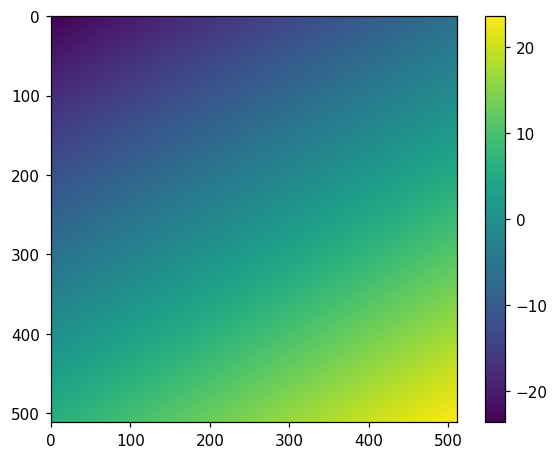

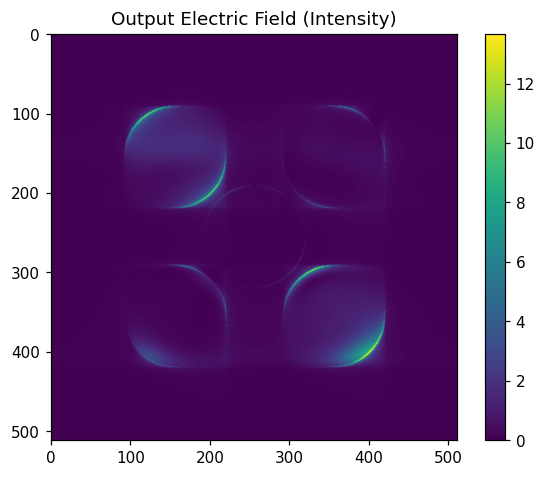

In [ ]:

def generate_tilt(shape, alpha):
    ny, nx = shape
    cx, cy = nx // 2, ny // 2

    # Coordinate rispetto al centro
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy
    X, Y = np.meshgrid(x, y)

    tiltX = X/np.max(X)
    tiltY = Y/np.max(Y) 

    tilt = tiltX * np.cos(alpha) + tiltY * np.sin(alpha)
    norm_tilt = (tilt-np.mean(tilt))/np.std(tilt)

    return norm_tilt

shape = np.shape(output_field)

scale = 10

plt.figure()
tt = generate_tilt(shape,np.pi/3)*scale
plt.imshow(tt)
plt.colorbar()

N = 16

tilted_input = input_field + tt
output_field = wfs.propagate(tilted_input)

# wfs_mod = PyramidWFS(apex_angle)
# output_field = wfs_mod.propagate(input_field)
# wfs_mod._ef_focal_plane_delayed *= np.exp(1j*tt)
# output_field = np.fft.ifft2(wfs_mod._ef_focal_plane_delayed, norm = 'ortho')

I = np.abs(output_field**2)

plt.figure()
plt.title("Output Electric Field (Intensity)")
plt.imshow(I)
plt.colorbar()
plt.show()


In [ ]:
def modulate(input, alpha, N_steps:int = 32):
    ny, nx = np.shape(input)
    cx, cy = nx // 2, ny // 2

    # Coordinates wrt center
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy
    X, Y = np.meshgrid(x, y)

    tiltX = X/np.max(X)
    tiltY = Y/np.max(Y) 

    intensity = np.zeros([ny,nx])

    for i in range(N_steps):
        phi = np.pi*2/N_steps*i
        tilt = tiltX * np.cos(phi) + tiltY * np.sin(phi)
        norm_tilt = (tilt-np.mean(tilt))/np.std(tilt)
        tilted_input = input + norm_tilt*alpha
        output = wfs.propagate(tilted_input)
        intensity += np.abs(output**2)/N_steps

    return intensity

alpha = 0.03*np.pi
modulated_intensity = modulate(input_field, alpha, N_steps = 16)

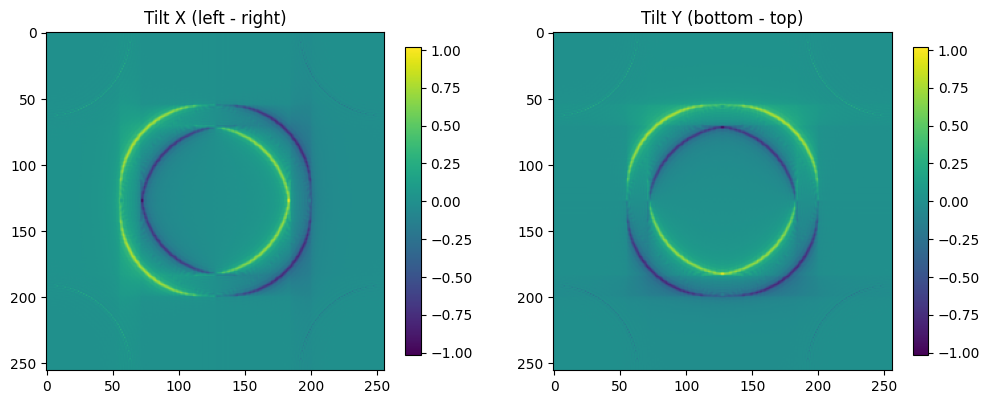

In [ ]:
def get_xy_images(I):
    ny, nx = np.shape(I)
    cx, cy = nx // 2, ny // 2

    # Coordinate rispetto al centro
    x = np.arange(nx) - cx
    y = np.arange(ny) - cy
    X, Y = np.meshgrid(x, y)

    A0 = I[X>=0] # left 
    A1 = I[X<0] # right

    Y0 = Y[X>=0] # left coordinates
    Y1 = Y[X<0] # right coordinates

    A00 = A0[Y0>=0] # bottom left
    A01 = A0[Y0<0] # top left
    A10 = A1[Y1>=0] # bottom right
    A11 = A1[Y1<0] # top right

    Ix = (A00+A01) - (A10+A11) # left - right
    Iy = (A00+A10) - (A01+A11) # bottom - top

    ImX = np.reshape(Ix,[int(nx/2),int(ny/2)])
    ImY = np.reshape(Iy,[int(nx/2),int(ny/2)])

    return ImX, ImY


ImX, ImY = get_xy_images(modulated_intensity)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(ImX)
plt.title('Tilt X (left - right)')
plt.colorbar(shrink=0.5)
plt.subplot(1,2,2)
plt.imshow(ImY)
plt.title('Tilt Y (bottom - top)')
plt.colorbar(shrink=0.5)